In [1]:
#引入函式庫
import random
import os
import numpy as np
import pandas as pd
import mplfinance as mpf
from datetime import datetime
import math
#取得路徑的所有檔案並過濾出.csv
path = os.getcwd()
#print(path)
list_csv = os.listdir(path)
#print(list_csv)
lists =  [file for file in list_csv if '.csv' in file]
#print(lists)

#### 策略
## 第四組 呂皇逸 陳冠勳 林殷嘉

### -挑選三種主要策略並依照貪心,隨機,優先序的方法買入(日線,KD,RSI)
  - (1) 貪心 : 若有一種以上訊號有買 且買的訊號多餘賣的訊號,則交易
  - (2) 隨機 : 隨機列出串列只要當天有符合抽到的訊號就交易
  - (3) 優先序 : 列出優先序,並依照優先序的訊號買賣,如:日線>KD>RSI則,日線買入訊號,RSI賣出訊號,則買入
  
## 額外:
    為了更精準地買與賣有額外判斷一周內的趨勢漲跌以及總漲幅是否大於總跌幅

# 1.計算KD線
## 買入點:
### K線向上突破D線
## 賣出點:
### K線向下突破D線

In [2]:
#定義常數
KD_n = 9
KDupperBound = 80
KDlowerBound = 20
middle_line = 50

def KD(ticker):
    tmp = pd.DataFrame(index=ticker.index)

    # 複製DataFrame當作結果
    # deep=True 代表複製而非指標
    data = ticker.copy(deep=True)

    tmp['max_close'] = ticker['Close'].rolling(KD_n, min_periods=1).max()
    tmp['min_close'] = ticker['Close'].rolling(KD_n, min_periods=1).min()

    tmp['RSV'] = (ticker['Close'] - tmp['min_close'])/(tmp['max_close']-tmp['min_close'])*100

    data['k'] = np.zeros(ticker.shape[0])
    data['d'] = np.zeros(ticker.shape[0])

    for i in range(1, tmp.shape[0]):

        # means data['k'][i]
        data.loc[(data.index[i], 'k')] = data['k'][i-1] * (2/3) + tmp['RSV'][i] * (1/3)
        data.loc[(data.index[i], 'd')] = data['d'][i-1] * (2/3) + data['k'][i] * (1/3)

    return data

# 2.計算RSI線
## 買入點 : RSI 向下突破15
## 賣出點 : RSI 向下突破85

In [3]:
#定義常數
RSI_n = 6
RSIupperBound = 90
RSIlowerBound = 10
RSImiddle_line = 50
strategy_1_upperbound = 85
strategy_1_lowerbound = 15

def RSI(ticker):
    tmp = pd.DataFrame(index=ticker.index)

    data = ticker.copy(deep=True)

    tmp['rise'] = ticker['Close'] - ticker['Open']

    tmp['rise_only'] = tmp['rise']
    tmp['drop_only'] = tmp['rise']

    tmp['rise_only'].loc[tmp['rise'] < 0] = 0
    tmp['drop_only'].loc[tmp['rise'] > 0] = 0

    tmp['rise_avg'] = tmp['rise_only'].rolling(RSI_n, min_periods=1).mean()
    tmp['drop_avg'] = tmp['drop_only'].rolling(RSI_n, min_periods=1).mean().abs()

    data['RSI'] = tmp['rise_avg'] / (tmp['rise_avg'] + tmp['drop_avg']) * 100
    return data

# 3.計算日線
## 買入點 : 5日線突破10日線買入
## 賣出點 : 10日線突破5日線賣出

In [4]:
def making_averages(days):
    days_mav = [np.nan] * (days-1)
    for i in range((days - 1) , len(stocks_close)):
        days_mav.append( sum( stocks_close[i - (days - 1): i+1]) / (days))
    return days_mav

# 4.實現'貪心'策略

In [5]:
def Best(KD_D,RSI_D,FiveMav,TenMav,i):
    BuySign = 0
    SellSign = 0
    #日線
    if(FiveMav[ i - 1 ] < TenMav[ i - 1] and FiveMav[i] > TenMav[i]):
        #print("MAV")
        BuySign += 1
    if(FiveMav[i - 1] > TenMav[i - 1] and FiveMav[i] < TenMav[i]):
        SellSign += 1
    #KD
    if(KD_D['k'][i] < 25):        
        # k 向上突破 d
        if((KD_D['k'][i-1] < KD_D['d'][i-1]) and
            (KD_D['k'][i]   > KD_D['d'][i]) and
            (KD_D['k'][i-1] < KD_D['k'][i])):
            
            BuySign += 1
    if(KD_D['k'][i] > 80):
        
        # k 向下突破 d
        if((KD_D['k'][i-1] > KD_D['d'][i-1]) and
            (KD_D['k'][i]   < KD_D['d'][i]) and
            (KD_D['k'][i-1] > KD_D['k'][i])):
            #print("KD")
            SellSign += 1
            
    if(RSI_D['RSI'][i] < strategy_1_lowerbound):
            
        BuySign += 1
    if(RSI_D['RSI'][i] > strategy_1_upperbound):
        #print("RSI")
        SellSign += 1
    # 買入訊號小於賣出訊號就賣出
    if(BuySign < SellSign and SellSign > 0):
        return -1
    # 買入訊號大於賣出訊號就買入
    if(BuySign > SellSign and BuySign > 0):
        return 1
    
    return 0

# 5.實現'隨機'策略

In [6]:
def randway(KD_D,RSI_D,FiveMav,TenMav,i,randlist):
    
    if(randlist[i] == 1):
        if(FiveMav[ i - 1 ] < TenMav[ i - 1] and FiveMav[i] > TenMav[i]):
            #print("MAV")
            return 1
        if(FiveMav[i - 1] > TenMav[i - 1] and FiveMav[i] < TenMav[i]):
            return -1
    if(randlist[i] == 2):
        if(KD_D['k'][i] < 25):
        
        # k 向上突破 d
            if((KD_D['k'][i-1] < KD_D['d'][i-1]) and
                (KD_D['k'][i]   > KD_D['d'][i]) and
                (KD_D['k'][i-1] < KD_D['k'][i])):

                return 1
        if(KD_D['k'][i] > 80):

            # k 向下突破 d
            if((KD_D['k'][i-1] > KD_D['d'][i-1]) and
                (KD_D['k'][i]   < KD_D['d'][i]) and
                (KD_D['k'][i-1] > KD_D['k'][i])):
                #print("KD")
                return -1
    if(randlist[i]==3):
        if(RSI_D['RSI'][i] < strategy_1_lowerbound):
            
            return 1
        if(RSI_D['RSI'][i] > strategy_1_upperbound):
            #print("RSI")
            return 1
    return 0

# 6.實現'優先序'策略

In [7]:
def priority(KD_D,RSI_D,FiveMav,TenMav,i):
    mav = 0
    kd = 0
    rsi = 0
    if(FiveMav[ i - 1 ] < TenMav[ i - 1] and FiveMav[i] > TenMav[i]):
        mav = 1
    if(FiveMav[i - 1] > TenMav[i - 1] and FiveMav[i] < TenMav[i]):
        mav = -1
    if(KD_D['k'][i] < 25):   
        # k 向上突破 d
        if((KD_D['k'][i-1] < KD_D['d'][i-1]) and
                (KD_D['k'][i]   > KD_D['d'][i]) and
                (KD_D['k'][i-1] < KD_D['k'][i])):
            kd = 1
    if(KD_D['k'][i] > 80):
        # k 向下突破 d
        if((KD_D['k'][i-1] > KD_D['d'][i-1]) and
                (KD_D['k'][i]   < KD_D['d'][i]) and
                (KD_D['k'][i-1] > KD_D['k'][i])):
            kd = -1
    if(RSI_D['RSI'][i] < strategy_1_lowerbound):
        rsi = 1
    if(RSI_D['RSI'][i] > strategy_1_upperbound):
        rsi = -1
    #依照優先序 回傳買入或賣出訊號
    if(mav == 1):
        #print("mav+")
        return 1
    if(mav == -1):
        #print("mav-")
        return -1
    if(kd == 1):
        #print("kd+")
        return 1
    if(kd == -1):
        #print("kd-")
        return -1
    if(rsi == 1):
        #print("rsi+")
        return 1
    if(rsi == -1):
        #print("rsi-")
        return -1

0050_2018.csv
['12/31', '-6648', 122.25, 122, '+809122', -710651, 809161]
支出:  500000 元
收入:  809161 元
淨收益:  309161 元
投資報酬率:  61.83 %


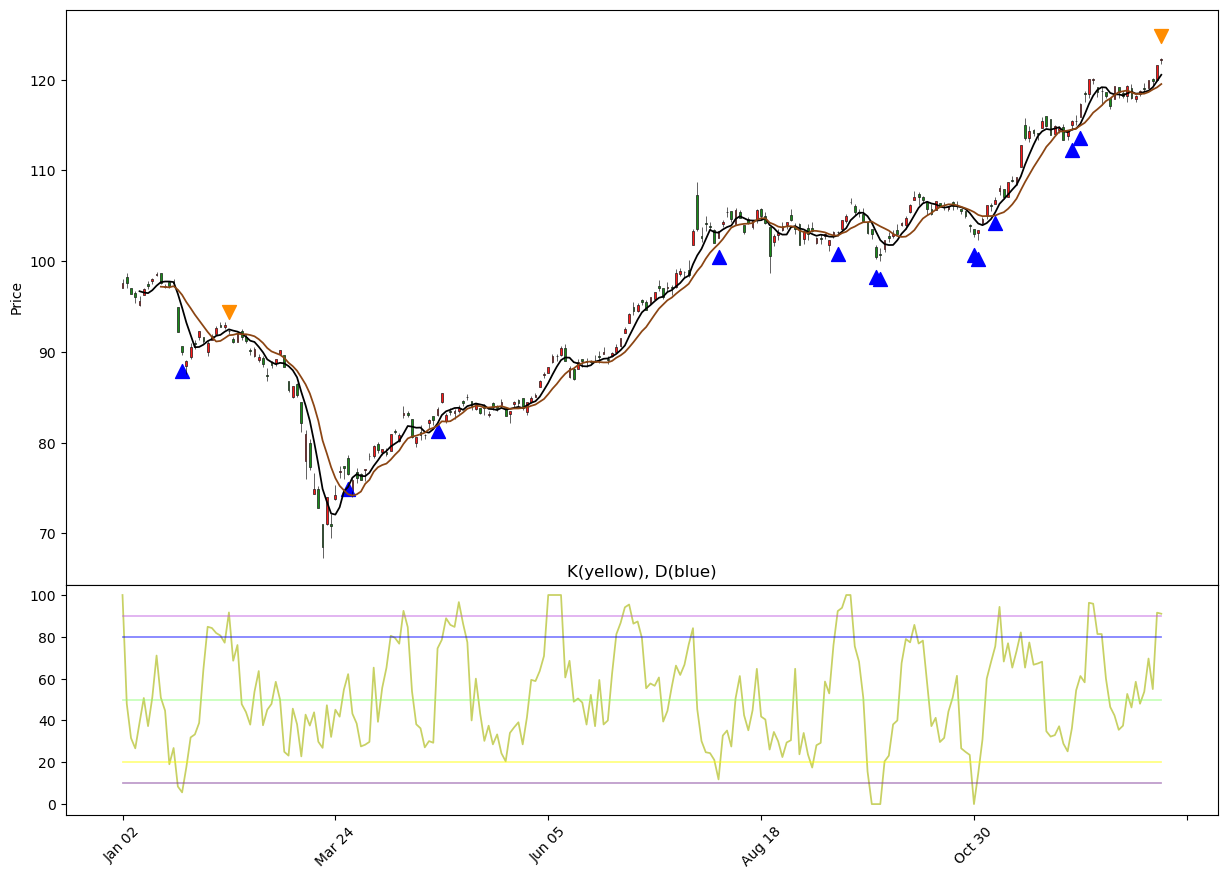

        0         1       2      3        4         5       6
0      日期  買/賣(+/-)      價格  價格(稅)     實際花費      目前獲利    剩餘金額
1    1/31     +5549   89.95   90.1  -499965   -499965      35
2    2/17     -5549    92.3     92  +509906  -1009871  509941
3    3/27     +6648    76.6   76.7  -509902  -1519773      39
4    4/29        +0    83.7   83.8       -0  -1519773      39
5     8/4        +0   103.3  103.4       -0  -1519773      39
6    9/11        +0  103.25  103.4       -0  -1519773      39
7    9/24        +0  100.45  100.6       -0  -1519773      39
8    9/25        +0  100.65  100.8       -0  -1519773      39
9   10/30        +0   103.0  103.1       -0  -1519773      39
10   11/2        +0   103.4  103.5       -0  -1519773      39
11   11/6        +0   106.7  106.9       -0  -1519773      39
12   12/2        +0   115.4  115.6       -0  -1519773      39
13   12/4        +0   117.3  117.5       -0  -1519773      39
14  12/31     -6648  122.25    122  +809122   -710651  809161
1304_201

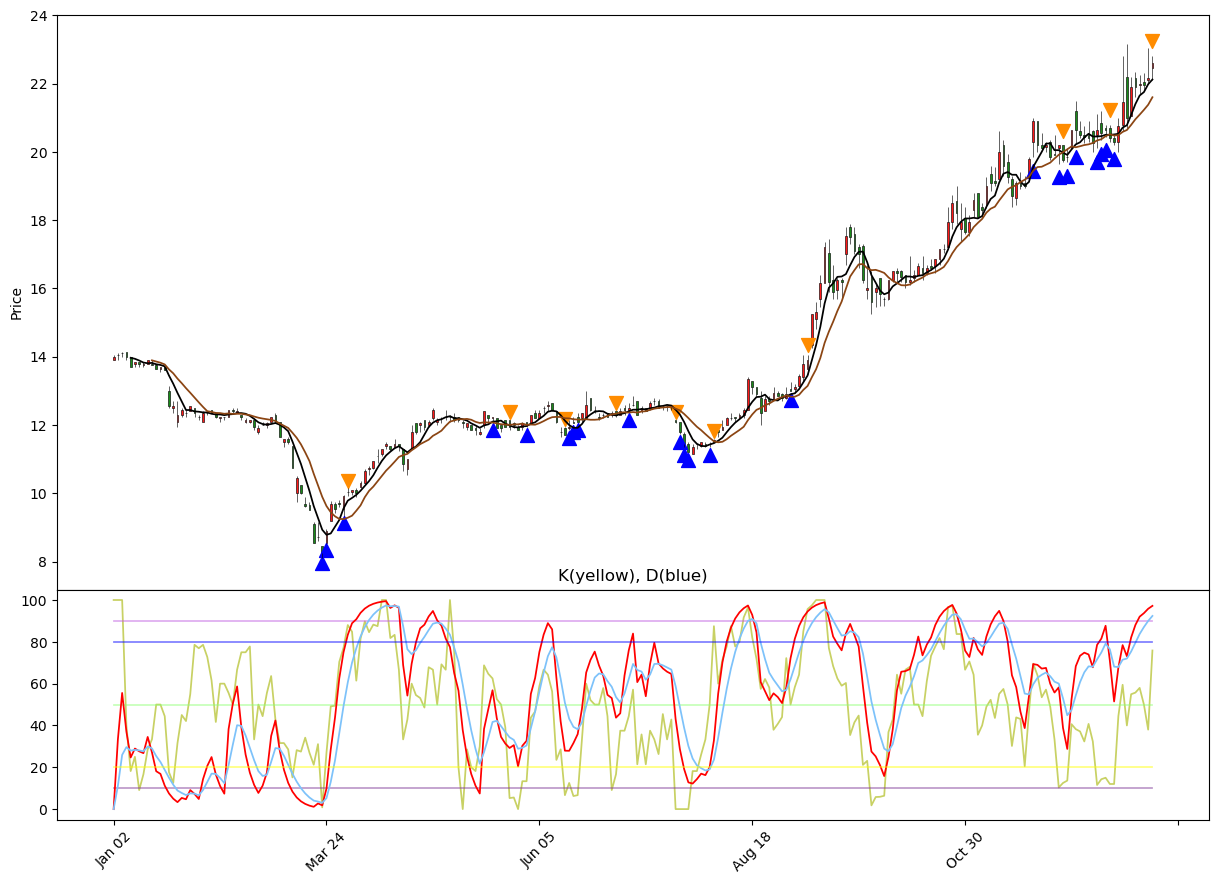

        0         1      2      3        4          5       6
0      日期  買/賣(+/-)     價格  價格(稅)     實際花費       目前獲利    剩餘金額
1    3/23    +60240   8.25    8.3  -499992    -499992       8
2    3/24        +0    8.9    8.9       -0    -499992       8
3    3/30        +0   9.93    9.9       -0    -499992       8
4    3/31    -60240  10.05     10  +602733   -1102725  602741
5    5/21    +49003  12.25   12.3  -602737   -1705462       4
6    5/27    -49003  11.95     12  +582995   -2288457  582999
7     6/2    +48583   12.0   12.0  -582996   -2871453       3
8    6/15    -48583   11.7     12  +565906   -3437359  565909
9    6/16    +47159  11.95   12.0  -565908   -4003267       1
10   6/17        +0  12.05   12.1       -0   -4003267       1
11   6/18        +0   12.1   12.1       -0   -4003267       1
12    7/3    -47159   12.3     12  +577489   -4580756  577490
13    7/8    +46199   12.5   12.5  -577488   -5158244       2
14   7/23    -46199   12.1     12  +556534   -5714778  556536
15   7/2

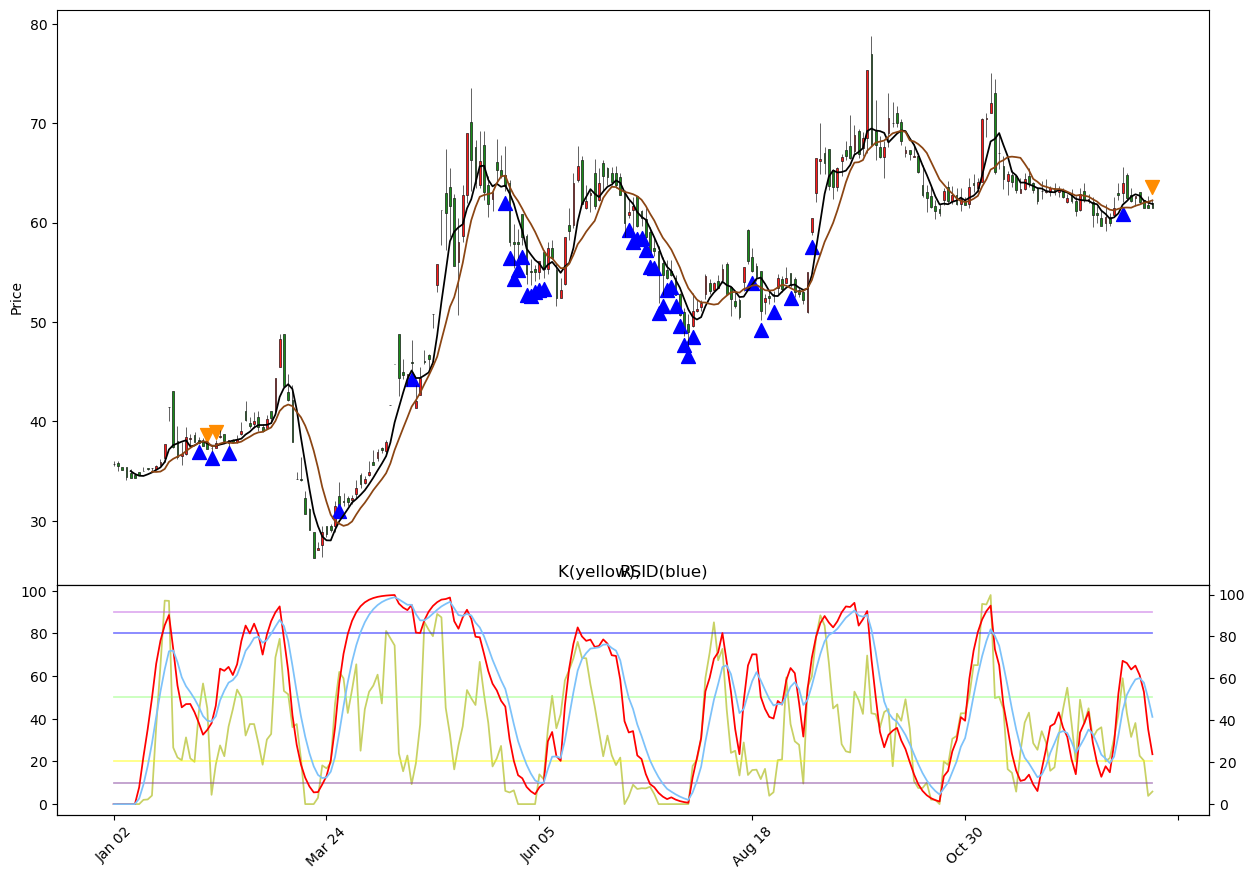

        0         1      2      3        4         5       6
0      日期  買/賣(+/-)     價格  價格(稅)     實際花費      目前獲利    剩餘金額
1    2/10    +13192  37.85   37.9  -499977   -499977      23
2    2/12    -13192   37.2     37  +488571   -988548  488594
3    2/13    +13064   37.3   37.4  -488594  -1477142       0
4    2/14    -13064   37.8     38  +491634  -1968776  491634
5    2/19    +12869   38.1   38.2  -491596  -2460372      38
6    3/27        +1   31.6   31.6      -32  -2460404       6
7    4/23        +0   45.9   46.0       -0  -2460404       6
8    5/26        +0   63.7   63.8       -0  -2460404       6
9    5/27        +0   58.0   58.1       -0  -2460404       6
10   5/28        +0   57.8   57.9       -0  -2460404       6
11   5/29        +0   57.8   57.9       -0  -2460404       6
12    6/1        +0   58.5   58.6       -0  -2460404       6
13    6/2        +0   54.8   54.9       -0  -2460404       6
14    6/3        +0   55.0   55.1       -0  -2460404       6
15    6/4        +0   55

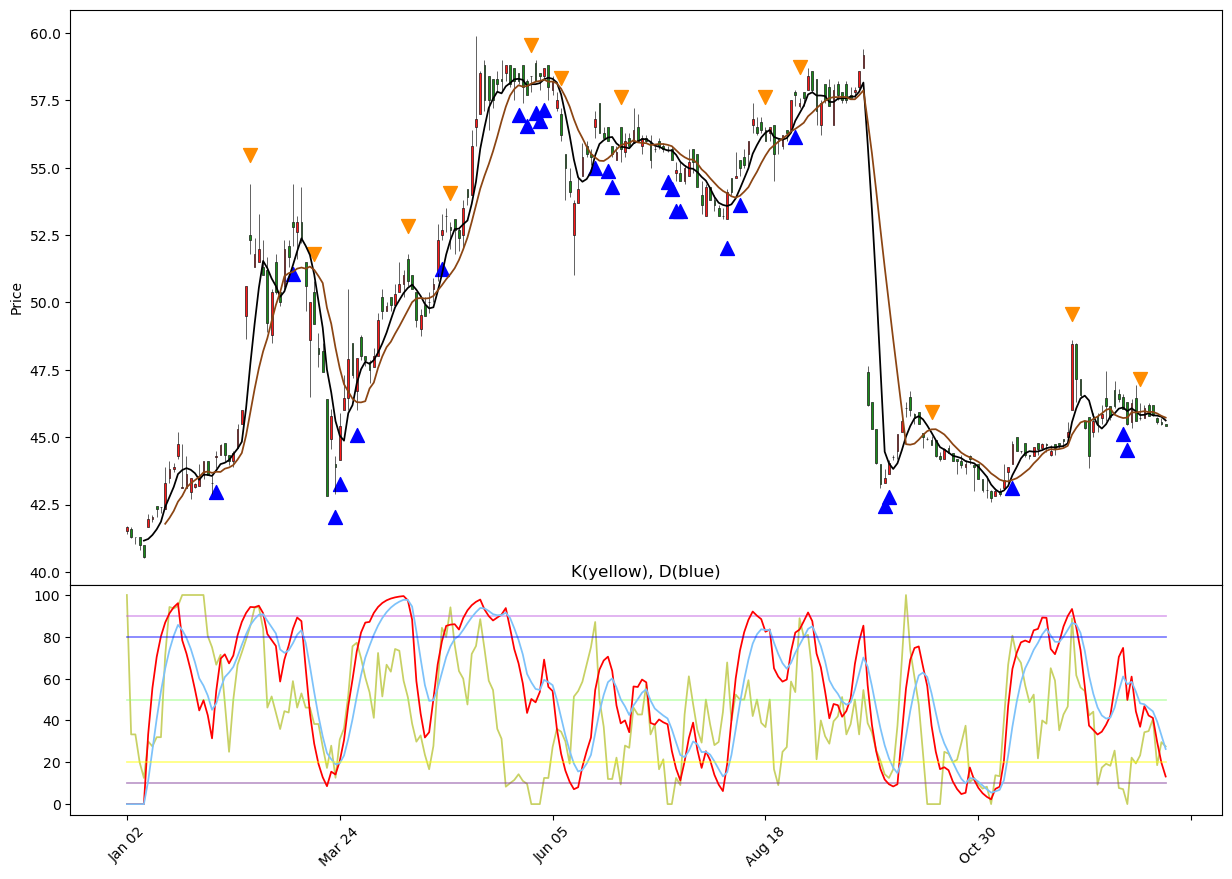

        0         1      2      3        4          5       6
0      日期  買/賣(+/-)     價格  價格(稅)     實際花費       目前獲利    剩餘金額
1    2/11    +11261   44.3   44.4  -499988    -499988      12
2    2/21    -11261   52.3     52  +586344   -1086332  586356
3     3/9    +11084   52.8   52.9  -586344   -1672676      12
4    3/16    -11084   49.2     49  +542920   -2215596  542932
5    3/23    +12339   43.9   44.0  -542916   -2758512      16
6    3/24        +0   45.4   45.5       -0   -2758512      16
7    3/30        +0  47.95   48.0       -0   -2758512      16
8    4/17    -12339   50.8     51  +624048   -3382560  624064
9    4/29    +11819   52.7   52.8  -624043   -4006603      21
10    5/4    -11819   52.7     52  +620105   -4626708  620126
11   5/26    +10636   58.2   58.3  -620079   -5246787      47
12   5/28        +0   57.7   57.8       -0   -5246787      47
13   5/29    -10636   58.4     58  +618394   -5865181  618441
14    6/1    +10607   58.2   58.3  -618388   -6483569      53
15    6/

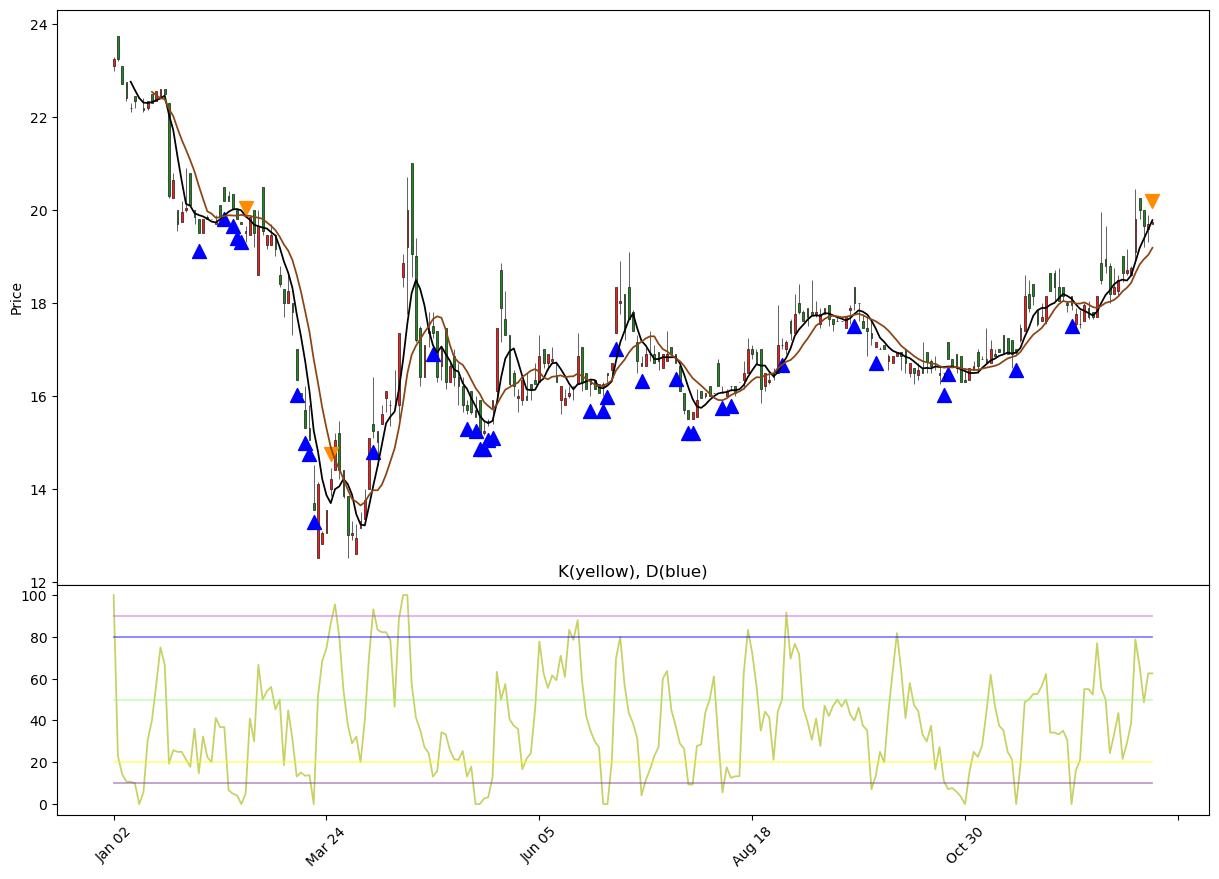

        0         1      2      3        4         5       6
0      日期  買/賣(+/-)     價格  價格(稅)     實際花費      目前獲利    剩餘金額
1    2/10    +25641   19.5   19.5  -500000   -500000       0
2    2/18        +0   20.2   20.2       -0   -500000       0
3    2/20        +0  20.05   20.1       -0   -500000       0
4    2/21        +0   19.8   19.8       -0   -500000       0
5    2/24        +0   19.7   19.7       -0   -500000       0
6    2/25    -25641  19.55     19  +499063   -999063  499063
7    3/13    +30430  16.35   16.4  -499052  -1498115      11
8    3/17        +0   15.3   15.3       -0  -1498115      11
9    3/18        +0  15.05   15.1       -0  -1498115      11
10   3/19        +0  13.55   13.6       -0  -1498115      11
11   3/25    -30430   14.2     14  +430194  -1928309  430205
12   4/10    +28117  15.25   15.3  -430190  -2358499      15
13   4/30        +0  17.35   17.4       -0  -2358499      15
14   5/13        +0   15.7   15.7       -0  -2358499      15
15   5/15        +0  15.

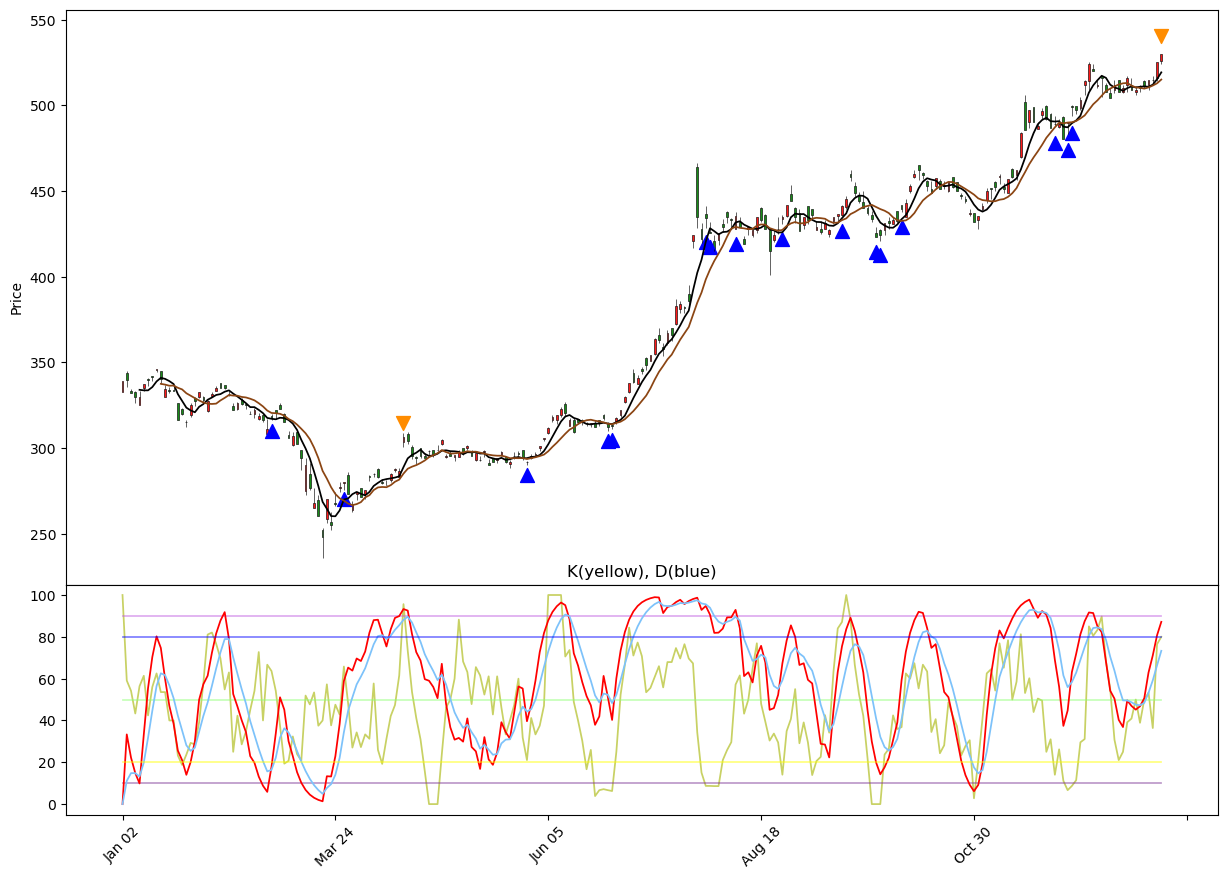

        0         1      2      3        4         5       6
0      日期  買/賣(+/-)     價格  價格(稅)     實際花費      目前獲利    剩餘金額
1     3/3     +1572  317.5  318.0  -499896   -499896     104
2    3/26        +0  280.0  280.4       -0   -499896     104
3    4/17     -1572  306.5    305  +479686   -979582  479790
4    5/29     +1640  292.0  292.4  -479536  -1459118     254
5    6/29        +0  312.0  312.4       -0  -1459118     254
6    6/30        +0  313.0  313.4       -0  -1459118     254
7    7/30        +0  434.0  434.6       -0  -1459118     254
8    7/31        +0  425.5  426.1       -0  -1459118     254
9    8/10        +0  435.5  436.1       -0  -1459118     254
10   8/25        +0  434.5  435.1       -0  -1459118     254
11   9/14        +0  441.0  441.6       -0  -1459118     254
12   9/24        +0  423.0  423.6       -0  -1459118     254
13   9/25        +0  424.0  424.6       -0  -1459118     254
14   10/6        +0  439.5  440.1       -0  -1459118     254
15  11/26        +0  489

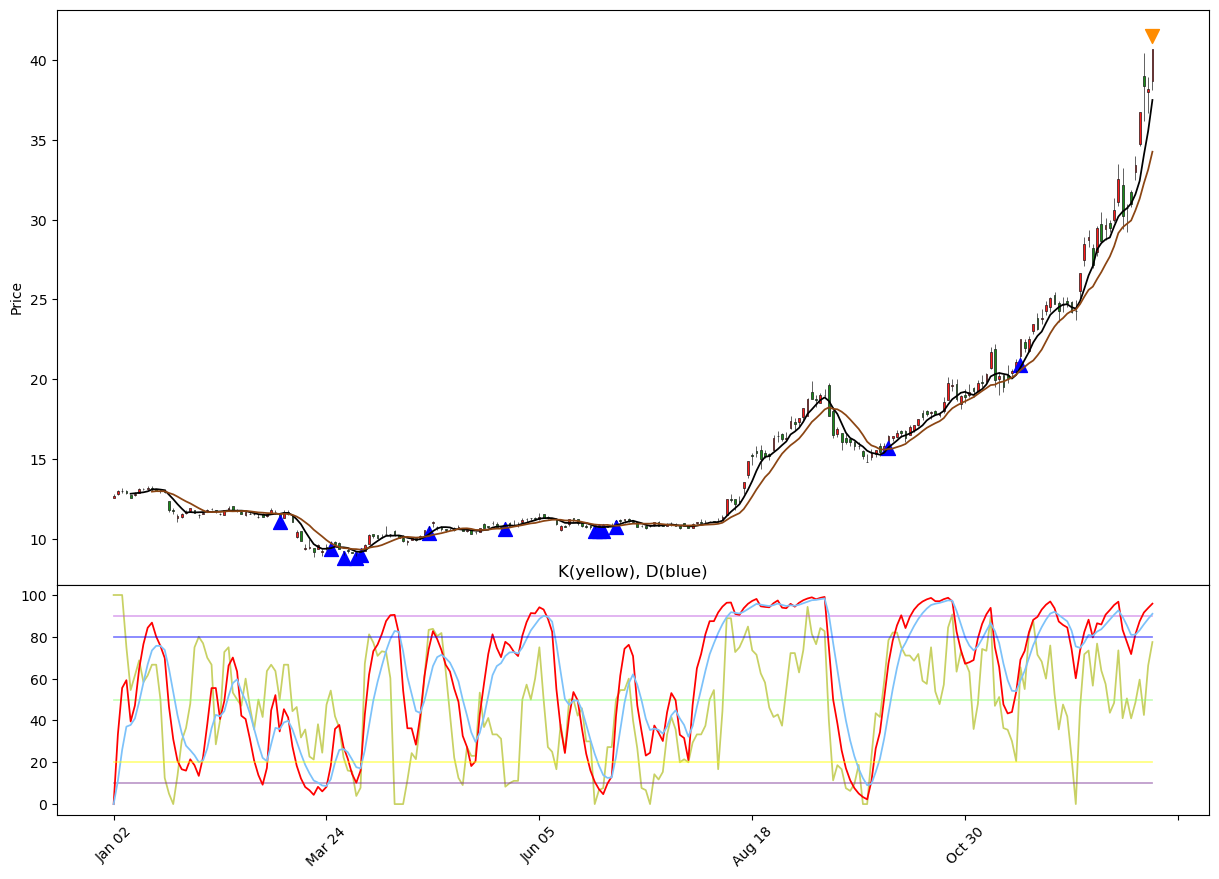

        0         1      2      3         4        5        6
0      日期  買/賣(+/-)     價格  價格(稅)      實際花費     目前獲利     剩餘金額
1     3/9    +43859   11.4   11.4   -499993  -499993        7
2    3/25        +0   9.68    9.7        -0  -499993        7
3    3/30        +0   9.23    9.2        -0  -499993        7
4     4/6        +0   9.11    9.1        -0  -499993        7
5     4/7        +0   9.26    9.3        -0  -499993        7
6    4/29        +0   10.7   10.7        -0  -499993        7
7    5/26        +0  10.95   11.0        -0  -499993        7
8    6/24        +0  10.75   10.8        -0  -499993        7
9    6/29        +0  10.75   10.8        -0  -499993        7
10   6/30        +0  10.75   10.8        -0  -499993        7
11    7/3        +0  11.15   11.2        -0  -499993        7
12   10/5        +0  16.45   16.5        -0  -499993        7
13  11/18        +0   22.5   22.5        -0  -499993        7
14  12/31    -43859   40.7     41  +1777162  1277169  1777169
2748_201

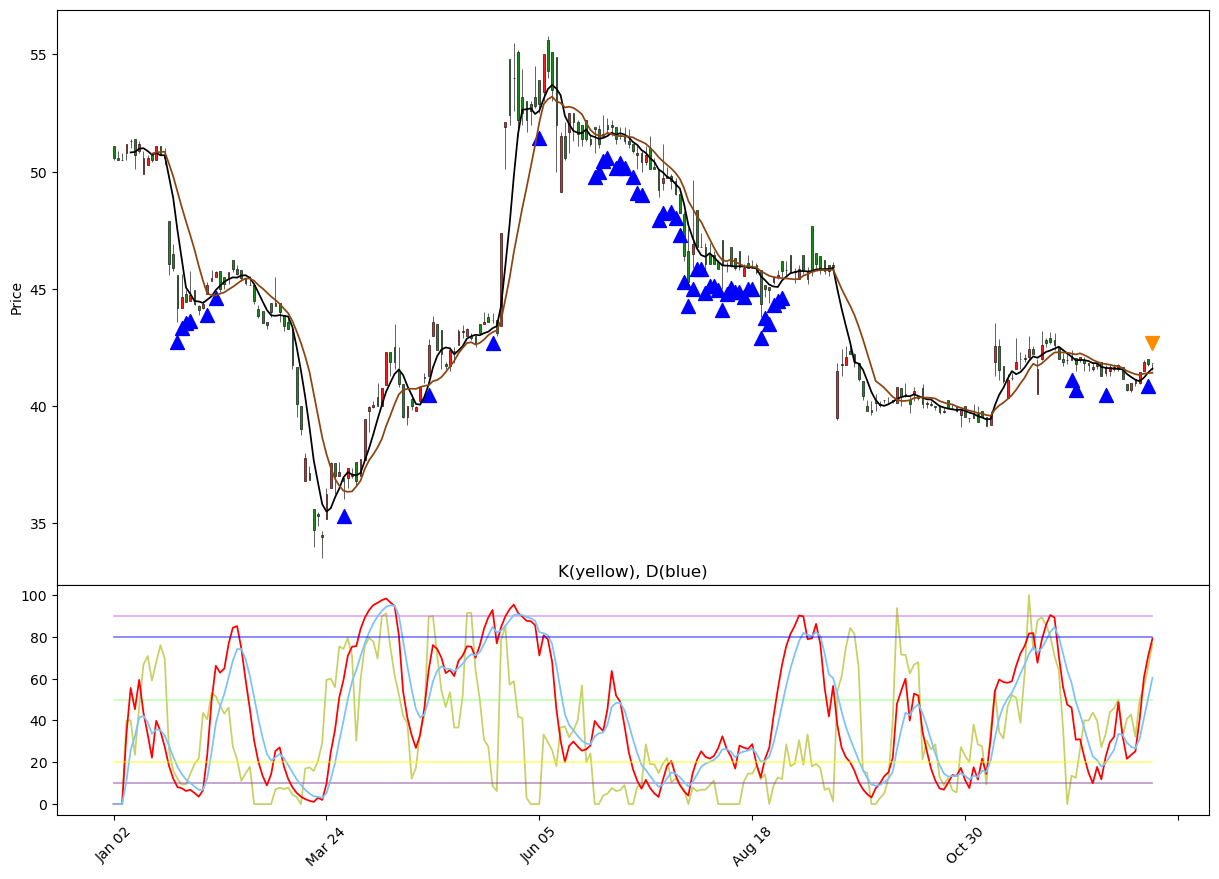

        0         1      2      3        4        5       6
0      日期  買/賣(+/-)     價格  價格(稅)     實際花費     目前獲利    剩餘金額
1     2/3    +11286   44.2   44.3  -499970  -499970      30
2     2/4        +0  44.65   44.7       -0  -499970      30
3     2/5        +0  44.45   44.5       -0  -499970      30
4     2/6        +0  44.75   44.8       -0  -499970      30
5    2/12        +0  45.15   45.2       -0  -499970      30
6    2/14        +0   45.7   45.8       -0  -499970      30
7    3/30        +0   36.8   36.9       -0  -499970      30
8    4/29        +0   42.6   42.7       -0  -499970      30
9    5/21        +0  43.65   43.7       -0  -499970      30
10    6/5        +0   52.9   53.0       -0  -499970      30
11   6/24        +0   51.8   51.9       -0  -499970      30
12   6/29        +0   51.2   51.3       -0  -499970      30
13   6/30        +0   51.6   51.7       -0  -499970      30
14    7/1        +0   51.8   51.9       -0  -499970      30
15    7/3        +0   51.4   51.5       

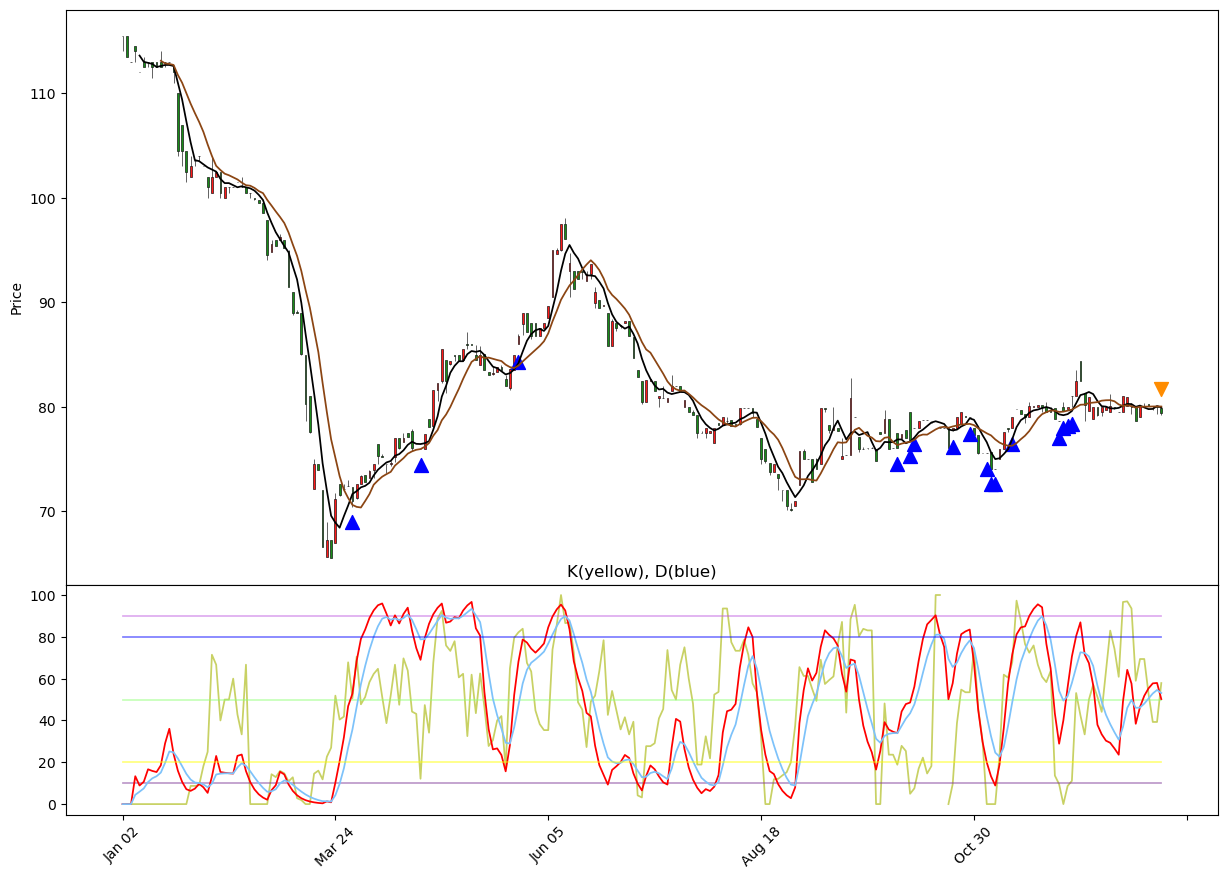

        0         1     2      3        4        5       6
0      日期  買/賣(+/-)    價格  價格(稅)     實際花費     目前獲利    剩餘金額
1    3/30     +7032  71.0   71.1  -499975  -499975      25
2    4/23        +0  76.0   76.1       -0  -499975      25
3    5/27        +0  86.8   86.9       -0  -499975      25
4    10/5        +0  76.1   76.2       -0  -499975      25
5    10/8        +0  76.8   76.9       -0  -499975      25
6   10/12        +0  78.0   78.1       -0  -499975      25
7   10/23        +0  78.0   78.1       -0  -499975      25
8   10/29        +0  79.0   79.1       -0  -499975      25
9    11/4        +0  75.6   75.7       -0  -499975      25
10   11/5        +0  74.1   74.2       -0  -499975      25
11   11/6        +0  74.1   74.2       -0  -499975      25
12  11/12        +0  79.0   79.1       -0  -499975      25
13  11/27        +0  78.6   78.7       -0  -499975      25
14  11/30        +0  79.6   79.7       -0  -499975      25
15   12/1        +0  80.0   80.1       -0  -499975      

In [10]:
for file in lists:
    #讀檔並把資料整理成需求的DATAFRAME
    print(file)
    stocks = pd.read_csv(file)
    stocks.columns = ['Date','Open','High','Low','Close','Volume']
    stocks = stocks.set_index(pd.DatetimeIndex(stocks["Date"]))
    stocks.iloc[:,0] = pd.to_datetime(stocks.iloc[:,0],format = "%Y/%m/%d")
    stocks = stocks.loc['2020-01-01':'2020-12-31',:]
    #設定股票圖的顏色,樣式等
    colorSet = mpf.make_marketcolors(up = 'r' , down = 'g')
    styleSet = mpf.make_mpf_style(marketcolors = colorSet)
    kwargs = dict(type = 'candle' , figscale = 2 ,style = styleSet)
    #將資料轉成浮點數mpf畫圖時才不會亂畫
    stocks_close = [float(line) for line in stocks['Close']]
    stocks_open = [float(line) for line in stocks['Open']]
    stocks_high = [float(line) for line in stocks['High']]
    stocks_low = [float(line) for line in stocks['Low']]
    RSIDATA = RSI(stocks) #計算RSI線
    KDDATA = KD(stocks)   #計算KD線
    FiveMav = making_averages(5)  #計算五日線
    TenMav = making_averages(10)  #計算十日線
    randlist = [random.randint(1,3) for i in range(0,len(stocks))] #產生隨機串列用於隨機策略
#############################################################################
    
    #策略實現
    
    #宣告買入即賣出串列作為儲存目標
    points_buy = [np.nan] * len(stocks)
    points_sell = [np.nan] * len(stocks)
    
    #初始金額
    initial = 500000
    money = initial
    
    #初始股票數
    stock = 0
    
    #每次交易單位
    unit = 1
    
    #所得
    gain = 0
    
    #此為計算跌幅或漲幅(VALUE)(怕股市大跌,訊號卻是上漲的,那我們就想說直到上漲幅度蓋過下跌幅度才買入green>0)
    green = 0
    
    #此為判斷若每次計算 green < 0 ,則down 指標-1,反之+1
    #在判斷買賣時 down > 0 or down < 0 也會成為判斷基準
    down = 0
    
    detail = [['日期','買/賣(+/-)','價格','價格(稅)','實際花費','目前獲利','剩餘金額']]
    
    temp_detail = []
    
    for i in range(11,len(stocks)):
        #紀錄漲跌
        green += stocks_close[i-1]-stocks_open[i-1]
        
        #用變數儲存使用策略使之轉換容易
        
        #貪心
        #n = Best(KDDATA , RSIDATA,FiveMav,TenMav,i) 
        
        #隨機
        #n = randway(KDDATA , RSIDATA,FiveMav,TenMav,i,randlist)
        
        #優先序
        n = priority(KDDATA , RSIDATA,FiveMav,TenMav,i) 
        
        #這邊為額外判斷一周內的股票走勢,相較於當日,是否皆為上升,屬於較為遲緩但穩定的交易策略
        if( stocks_close[i-1] > stocks_close[i-7] and
            stocks_close[i-1] > stocks_close[i-5] and 
            stocks_close[i-1] > stocks_close[i-3] and
            green < 0):
            down += 1
        #若跌的程度未蓋過漲的程度就把 down -= 1
        if( green > 0):
            down -= 1
            
        #若交易策略有買入訊號,且上漲得天數>下跌的天數則買入
        if(n == 1 & down > 0):
            price = round(stocks_close[i] * 1.001425,1)
            num = math.floor(money/price)
            buy = round(num*price)
            money = money - buy
            
            gain -= buy
            
            points_buy[i] = stocks_low[i] * 0.98
            
            temp_detail.append(str(datetime.date(stocks['Date'][i]).month) + '/' + str(datetime.date(stocks['Date'][i]).day))
            temp_detail.append('+'+str(num))
            stock += num
            temp_detail.append(stocks_close[i])
            temp_detail.append(price)
            temp_detail.append('-'+str(buy))
            temp_detail.append(gain)
            temp_detail.append(money)
            detail.append(temp_detail)
            temp_detail=[]
        
        #若交易策略有買入訊號,且上漲得天數<下跌的天數則買入
        if(n == -1 and stock > 0  and down < 0):
            
            sell = round(stocks_close[i] * 0.995575 * stock)
            money = money + sell
            
            points_sell[i] = stocks_high[i] * 1.02
            
            gain -= sell
            
            temp_detail.append(str(datetime.date(stocks['Date'][i]).month) + '/' + str(datetime.date(stocks['Date'][i]).day))
            temp_detail.append('-' + str(stock))                                           #股票全部賣出
            temp_detail.append(stocks_close[i])                                            #賣出日賣出價格: "收盤價"
            temp_detail.append(round(stocks_close[i] * 0.995575))                          #抽稅之後的價格(含稅)
            temp_detail.append('+' + str(sell))                                            #實際收入 (四捨五入到個位數)
            temp_detail.append(gain)                                                       #目前獲利
            temp_detail.append(money)                                                      #剩餘金額
            stock = 0                                                                      #因為全部股票賣出，所以當前股票張數歸零
            detail.append(temp_detail)                                                     #紀錄交易資訊至正是表格中
            temp_detail = [] 
            
            
    if(stock!=0):
        sell = round(stocks_close[i] * 0.995575 * stock)                               #計算實際收入
        money = money + sell                                                           # 更新 money

        #繪製點所使用的陣列， 賣出日最高價 * 1.02方便觀看
        points_sell[i] = stocks_high[i] * 1.02
        #淨收益計算
        gain += sell

        #交易資訊(日期)
        temp_detail.append(str(datetime.date(stocks['Date'][i]).month) + '/' + str(datetime.date(stocks['Date'][i]).day))
        temp_detail.append('-' + str(stock))                                           #股票全部賣出
        temp_detail.append(stocks_close[i])                                            #賣出日賣出價格: "收盤價"
        temp_detail.append(round(stocks_close[i] * 0.995575))                          #抽稅之後的價格(含稅)
        temp_detail.append('+' + str(sell))                                            #實際收入 (四捨五入到個位數)
        temp_detail.append(gain)                                                       #目前獲利
        temp_detail.append(money)                                                      #剩餘金額
        stock = 0                                                                      #因為全部股票賣出，所以當前股票張數歸零
        detail.append(temp_detail)                                                     #紀錄交易資訊至正是表格中
        print(temp_detail)
        temp_detail = []
        
    cost = initial
    income = money
    print("支出: ",cost,"元")
    print("收入: ",income,"元")
    print("淨收益: ",income - cost ,"元")
    print("投資報酬率: ",round(100*(income-cost)/cost,2),"%")
    
    addplots = [
                #畫出買點
                mpf.make_addplot(points_buy,type = 'scatter', color = 'blue' , marker = '^' , markersize = 100),
                mpf.make_addplot(points_sell,type = 'scatter' , color = 'darkorange' , marker = 'v',markersize = 100),
                #畫出日線
                mpf.make_addplot(FiveMav , color = 'black'),
                mpf.make_addplot(TenMav, color = 'saddlebrown'),
                #畫出RSI線
                mpf.make_addplot(RSIDATA['RSI'], panel = 1, color='#c8d164', title='RSI'),
    
                # 畫出RSI上下界
                mpf.make_addplot(np.full((len(RSIDATA)), RSIupperBound), panel = 1, color='#bf5ce0', alpha=0.5),
                mpf.make_addplot(np.full((len(RSIDATA)), RSIlowerBound), panel = 1, color='#7e3696', alpha=0.5),
                mpf.make_addplot(np.full((len(RSIDATA)), RSImiddle_line), panel = 1, color='#8eff75', alpha=0.5),
                
                #畫出KD線
                mpf.make_addplot(KDDATA['k'], panel = 1, color='red', title='K(yellow), D(blue)'),
                mpf.make_addplot(KDDATA['d'], panel = 1, color='#7dc2fa'),

                #畫出KD上下界
                mpf.make_addplot(np.full((len(KDDATA['k'])), KDupperBound), panel = 1, color='blue', alpha=0.5),
                mpf.make_addplot(np.full((len(KDDATA['d'])), KDlowerBound), panel = 1, color='yellow', alpha=0.5),
                ]
    #if(file == "1304_2011.csv"):
    mpf.plot(stocks, **kwargs, addplot = addplots)
    #print("初始金額:", initial, '元')
    detail = pd.DataFrame(detail)
    print(detail)
    #print()